In [2]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from scipy.stats import gamma, norm

In [6]:
samples_count = 1000
iters_count = 10000

h0_a = 2.0
h0_scale = 0.5
h0_samples = gamma.rvs(a=h0_a, scale=h0_scale, size=(iters_count, samples_count))

h1_a = 2.0
h1_scale = 1.0
h1_samples = gamma.rvs(a=h1_a, scale=h1_scale, size=(iters_count, samples_count))

Взглянем на гистограммы распределений при различных параметрах

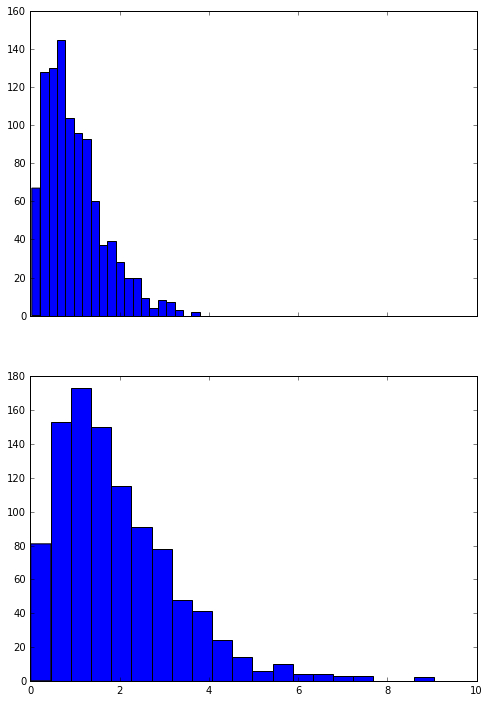

In [8]:
f, axes = plt.subplots(2, 1, figsize = (8, 12), sharex=True)
axes[0].hist(h0_samples[0], bins=20)
axes[1].hist(h1_samples[0], bins=20)
plt.show()

Гипотеза $H_0$: $E[X_1] = 1$

Будем рассматривать статистику

$$ T(X) = \frac{\sum_{i=1}^{n}X_i - n\mu}{\sqrt{ns^2}} $$

In [10]:
def calc_wald_statistics(X, samples_count, assumed_mean):
    X = np.array(X)[: samples_count]
    n = len(X) 
    return (X.sum() - n * assumed_mean) / np.sqrt(n * X.var(ddof=1))

def calc_wald_statistics_multirow(X, samples_count, assumed_mean):
    X = np.array(X)[:, : samples_count]
    n = X.shape[1] 
    return (X.sum(axis=1) - n * assumed_mean) / np.sqrt(n * X.var(ddof=1, axis=1))

При $H_0$ статистика Вальда стремится к $N(0, 1)$ с ростом количества элементов выборки. Тест устроен следующим образом:

Если $|T(X)| > u_{1-\alpha/2}$, то гипотеза $H_0$ отвергается, иначе $H_0$ принимается. Будем проводить тест с уровнем значимости $\alpha = 0.05$. 


In [11]:
alpha = 0.05
norm_threshold = norm.ppf(1.0 - 0.5 * alpha)

Но ведь статистика Вальда имеет не нормальное распределение, а лишь стремится к нему, поэтому заявленный уровень значимости (0.05) будет отличаться от истинного. Попробуем оценить истинный уровень значимости.

In [12]:
h0_stat_values = calc_wald_statistics_multirow(h0_samples, 1000, h0_a * h0_scale)

In [13]:
np.sum(np.abs(h0_stat_values) > norm_threshold) / float(iters_count)

0.052600000000000001

Теперь посмотрим на истинный уровень значимости при различных $n$

In [14]:
from tqdm import tqdm

In [15]:
significance_levels = list()
estimated_true_thresholds = list()

for n in tqdm(xrange(10, 1000 + 1, 10)):
    h0_stat_values = calc_wald_statistics_multirow(h0_samples, n, h0_a * h0_scale)
    
    significance_levels.append(np.sum(np.abs(h0_stat_values) > norm_threshold) / float(iters_count))
    estimated_true_thresholds.append(np.percentile(np.abs(h0_stat_values), (1.0 - alpha) * 100.0))

100%|██████████| 100/100 [00:08<00:00,  7.65it/s]


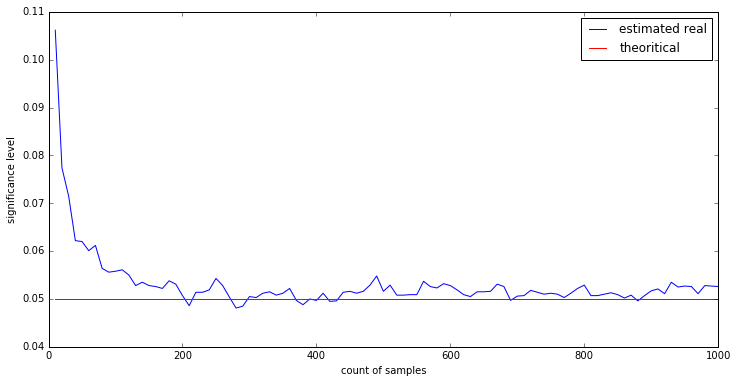

In [16]:
plt.figure(figsize(12, 6))
plt.xlabel("count of samples")
plt.ylabel("significance level")
plt.plot(range(10, 1000 + 1, 10), significance_levels, label="estimated real")
plt.plot(range(10, 1000 + 1, 10), [alpha for _ in range(10, 1000 + 1, 10)], color='red', label="theoritical")
plt.legend(loc = 1)

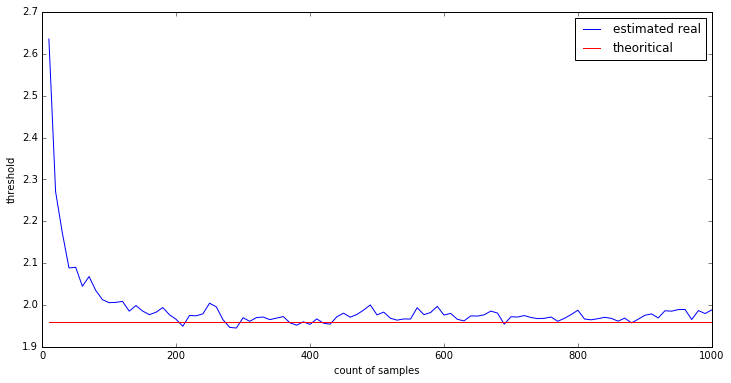

In [17]:
plt.figure(figsize(12, 6))
plt.xlabel("count of samples")
plt.ylabel("threshold")
plt.plot(range(10, 1000 + 1, 10), estimated_true_thresholds, label="estimated real")
plt.plot(range(10, 1000 + 1, 10), [norm_threshold for _ in range(10, 1000 + 1, 10)], color='red', label="theoritical")
plt.legend(loc = 1)

Теперь рассмотрим ситуацию, когда гипотеза $H_0$ неверна, и распределение имеет, к примеру, параметры a=2.0, scale=1.0

Каким же будет матожидание статистики Вальда при таком распределении $X$?

In [18]:
estimated_real_powers = list()
theoretical_powers = list()

for n in tqdm(xrange(10, 100 + 1)):
    h1_stat_values = calc_wald_statistics_multirow(h1_samples, n, h0_a * h0_scale)
    
    estimated_real_powers.append(np.sum(np.abs(h1_stat_values) > norm_threshold) / float(iters_count))
    theoretical_powers.append(
        norm.cdf(-norm_threshold, 
                 loc=sqrt(n) * (h1_a * h1_scale - h0_a * h0_scale) / sqrt(h1_a * h1_scale ** 2), 
                 scale=1.0) + 
        1.0 - 
        norm.cdf(norm_threshold, 
                 loc=sqrt(n) * (h1_a * h1_scale - h0_a * h0_scale) / sqrt(h1_a * h1_scale ** 2), 
                 scale=1.0))

100%|██████████| 91/91 [00:03<00:00, 22.44it/s]


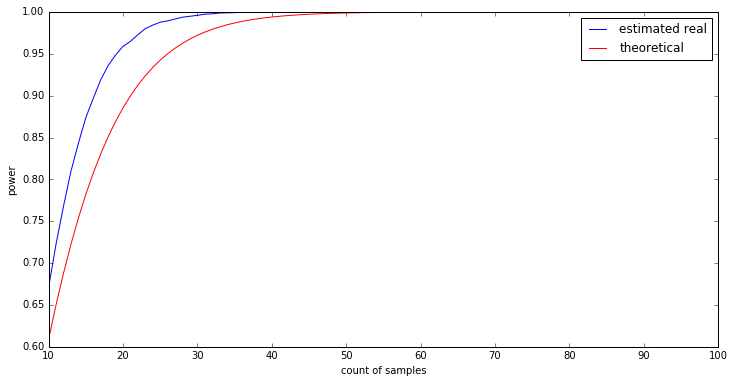

In [19]:
plt.figure(figsize(12, 6))
plt.xlabel("count of samples")
plt.ylabel("power")
plt.plot(range(10, 100 + 1), estimated_real_powers, label="estimated real")
plt.plot(range(10, 100 + 1), theoretical_powers, label="theoretical", color="red")
plt.legend(loc = 1)

In [20]:
from scipy.stats import ttest_1samp

In [22]:
ttest_1samp(np.random.randn(10), 0.0)

Ttest_1sampResult(statistic=0.99009452156812594, pvalue=0.34799819166878754)

In [ ]:
plt.hist(ttest_1samp)